In [1]:
import cPickle
import string
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import gc
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import model_eval

%matplotlib inline


DATA_TRAIN_PATH = '../input/train.csv'
DATA_TEST_PATH = '../input/test.csv'
LIN_DATA_TRAIN_PATH = '../input/lin_train.csv'
LIN_DATA_TEST_PATH = '../input/lin_test.csv'
IMG_PATH = '../images/'

### These variables perform better with OHE
ohe_list = ['cat73', 'cat93', 'cat112']

### These dicts are to re-encode cat112 to state abbreviations
swap_to_num = {'cat112': {'A': 0, 'AA': 25, 'AB': 26, 'AC': 27, 'AD': 28,
'AE': 29, 'AF': 30, 'AG': 31, 'AH': 32, 'AI': 33, 'AJ': 34, 'AK': 35, 'AL': 36,
'AM': 37, 'AN': 38, 'AO': 39, 'AP': 40, 'AQ': 41, 'AR': 42, 'AS': 43, 'AT': 44,
'AU': 45, 'AV': 46, 'AW': 47, 'AX': 48, 'AY': 49, 'B': 1, 'BA': 50, 'C': 2,
'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11,
'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}}

swap_to_state = {'cat112': {0: 'AL', 1: 'AK', 2: 'AZ', 3: 'AR', 4: 'CA',
5: 'CO', 6: 'CT', 7: 'DE', 8: 'DC', 9: 'FL', 10: 'GA', 11: 'HI', 12: 'ID',
13: 'IL', 14: 'IN', 15: 'IA', 16: 'KS', 17: 'KY', 18: 'LA', 19: 'ME', 20: 'MD',
21: 'MA', 22: 'MI', 23: 'MN', 24: 'MS', 25: 'MO', 26: 'MT', 27: 'NE', 28: 'NV',
29: 'NH', 30: 'NJ', 31: 'NM', 32: 'NY', 33: 'NC', 34: 'ND', 35: 'OH', 36: 'OK',
37: 'OR', 38: 'PA', 39: 'RI', 40: 'SC', 41: 'SD', 42: 'TN', 43: 'TX', 44: 'UT',
45: 'VT', 46: 'VA', 47: 'WA', 48: 'WV', 49: 'WI', 50: 'WY'}}

### Helper functions
def convert_cat_to_num(data):
    translation = list(string.ascii_uppercase)[:-1]
    for elem_i in translation[:13]:
        for elem_j in translation[:25]:
            translation.append(elem_i + elem_j)
    for i in range(len(translation)):
        data.replace(translation[i], i, inplace=True)
    data.replace('ZZ', -1, inplace=True)
    return


### Read the data in and prepare
log_y = 436.28279443805883
train = pd.read_csv(DATA_TRAIN_PATH, dtype={'id': np.int32})
train = train.replace(swap_to_num).replace(swap_to_state)
train = pd.get_dummies(train, columns=ohe_list)
convert_cat_to_num(train)
train['logloss'] = np.log(train['loss']+log_y)
test = pd.read_csv(DATA_TEST_PATH, dtype={'id': np.int32})
test = test.replace(swap_to_num).replace(swap_to_state)
test = pd.get_dummies(test, columns=ohe_list)
convert_cat_to_num(test)
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
num_feats = [feat for feat in test.columns if 'cont' in feat]
#lin_feats = [feat for feat in test.columns if 'lin' in feat]
#for col in lin_feats:
#    train[col] = train[col]/float(train_test[col].max())

cat_feats = [feat for feat in test.columns if 'cat' in feat]
prob_ordered=[]
for elem in cat_feats:
    if train_test[elem].nunique()!=train_test[elem].max()+1:
        prob_ordered.append(elem)

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


Now to set a baseline evaluation.

In [2]:
folds = 5
early_stop = 40
### Through HyperOpt, found best log_y value to be 
log_y = 436.28279443805883

scores = {}

scores['base_log'] = model_eval.xgb_quick_eval(train.drop(['loss','logloss'], axis=1),
    np.log(train['loss']+log_y), folds=folds, log_y=log_y, booster='gbtree', early_stop=early_stop)

[0]	train-mae:6.67231	eval-mae:6.67347
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 40 rounds.
[200]	train-mae:0.31778	eval-mae:0.335726
[400]	train-mae:0.30575	eval-mae:0.334385
Stopping. Best iteration:
[447]	train-mae:0.303322	eval-mae:0.334205

Average eval-MAE: 1147.887799

Means: actual=3037.33768567, predicted=2722.70825195
Medians: actual=2115.57, predicted=2060.03076172
 Time taken: 2.0 min and 13.72 sec


In [56]:
def plot_resid_cont_loss(x_col, y_col='logloss', path='', size=10, data=train):
    tmp_data = data[[x_col,y_col]].copy()
    linear_model = smf.ols(y_col +' ~ '+ x_col, tmp_data).fit()
    tmp_data['residuals'] = linear_model.resid
    tmp_data[x_col] = pd.cut(tmp_data[x_col], bins=100)
    tmp_data = tmp_data.groupby(by=x_col)['residuals']
    tmp_data_mean = tmp_data.mean()
    tmp_data_std = tmp_data.std()
    tmp_data_count = tmp_data.count()
    tmp_data = tmp_data.quantile([.25,.5,.75]).unstack()
    tmp_data['MEAN'] = tmp_data_mean
    tmp_data['COUNT_SCALED'] = tmp_data_count/float(tmp_data_count.max())*float(tmp_data[.75].max())
    tmp_data['COUNT'] = tmp_data_count
    ax = tmp_data.iloc[:,-3:-1].plot(marker='o', markersize=4)
    return tmp_data

In [7]:
for df in df_cut:
    print df[[0,1,2,3,5]]

                         0.25       0.5      0.75      MEAN  COUNT
cont1                                                             
(-0.000969, 0.0197] -0.439992  0.077792  0.685258  0.158422    259
(0.0197, 0.0394]          NaN       NaN       NaN       NaN      0
(0.0394, 0.0591]    -0.276227  0.190006  0.611695  0.159789    185
(0.0591, 0.0788]    -0.472262  0.043043  0.590280  0.114764    271
(0.0788, 0.0985]    -0.456976  0.009573  0.453402 -0.003330    173
(0.0985, 0.118]     -0.528452 -0.034472  0.405266 -0.033490    984
(0.118, 0.138]      -0.453003  0.018448  0.619496  0.084507    630
(0.138, 0.158]      -0.501119 -0.031476  0.547995  0.038289   1424
(0.158, 0.177]      -0.462028 -0.016996  0.418065 -0.010505    497
(0.177, 0.197]      -0.431936  0.093795  0.517365  0.072798    976
(0.197, 0.217]      -0.490451 -0.015247  0.424369  0.000522   1200
(0.217, 0.236]      -0.519940 -0.052553  0.493044  0.000450   3274
(0.236, 0.256]      -0.503193 -0.075015  0.455587 -0.011513   

In [58]:
def plot_zscore_cont_loss(x_col, y_col='logloss', path='', size=10, data=train):
    tmp_data = data[[x_col,y_col]].copy()
    linear_model = smf.ols(y_col +' ~ '+ x_col, tmp_data).fit()
    tmp_data['residuals'] = linear_model.resid
    mu = tmp_data['residuals'].mean()
    sigma = tmp_data['residuals'].std()
    tmp_data[x_col] = pd.cut(tmp_data[x_col], bins=200)
    tmp_data = tmp_data.groupby(by=x_col)['residuals']
    tmp_data_mean = tmp_data.mean()
    tmp_data_std = tmp_data.std()
    tmp_data_count = tmp_data.count()
    tmp_data = tmp_data.quantile([.25,.5,.75]).unstack()
    tmp_data['ZSCORE'] = tmp_data_mean * np.sqrt(tmp_data_count) / sigma
    tmp_data['MEAN'] = tmp_data_mean
    tmp_data['COUNT_SCALED'] = tmp_data_count/float(tmp_data_count.max())*float(tmp_data[.75].max())
    tmp_data['COUNT'] = tmp_data_count
    plt.figure()
    tmp_data.loc[:,'ZSCORE'].plot(marker='o', markersize=4)
    plt.axhline(3, ls='--', c='r')
    plt.axhline(-3, ls='--', c='r')
    print "mu={}, sigma={}".format(mu, sigma)
    return tmp_data

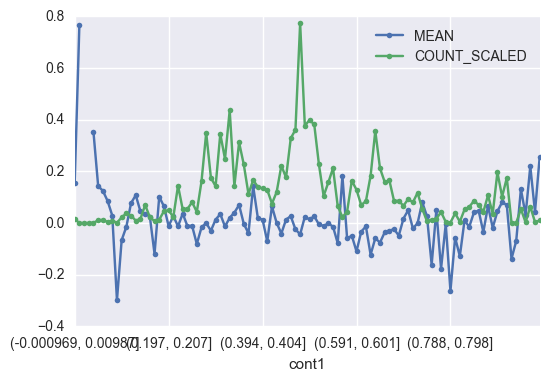

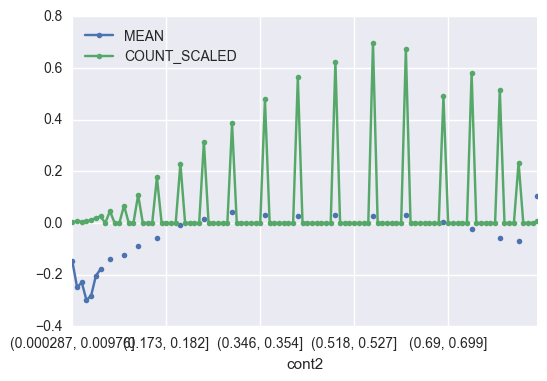

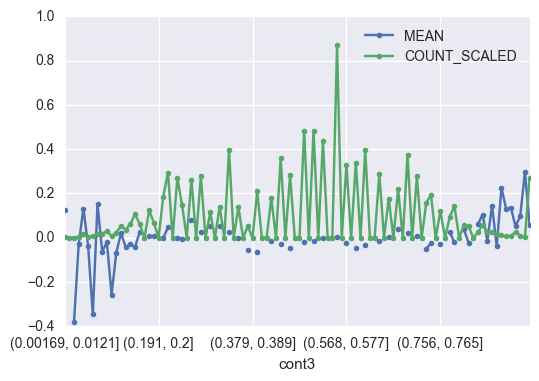

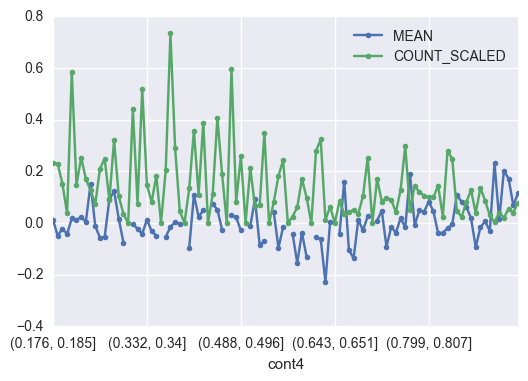

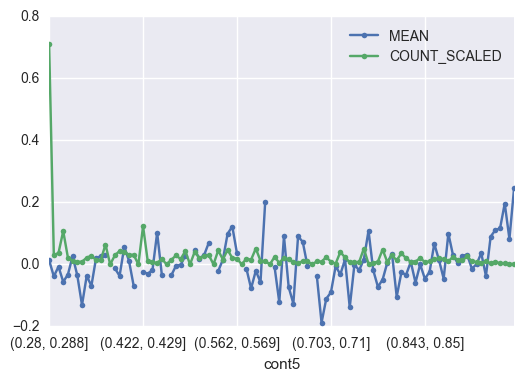

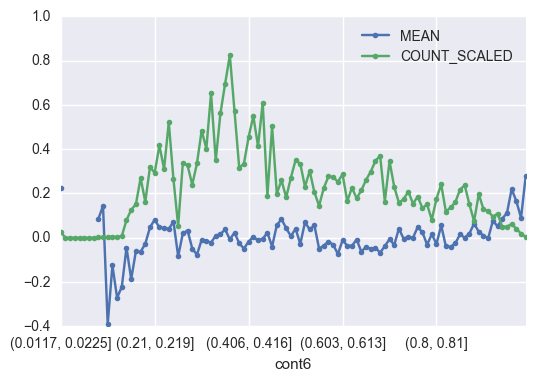

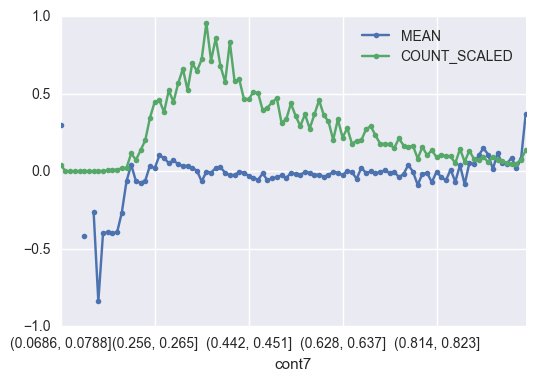

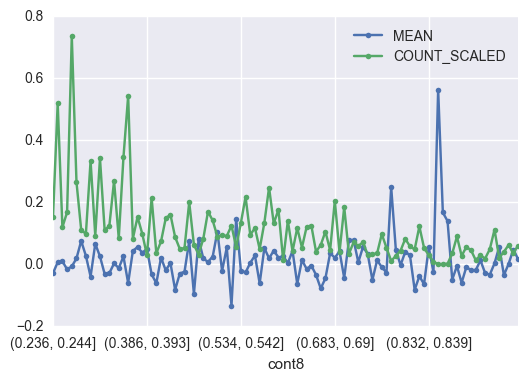

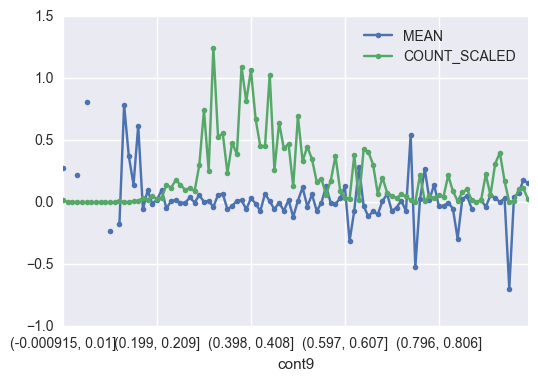

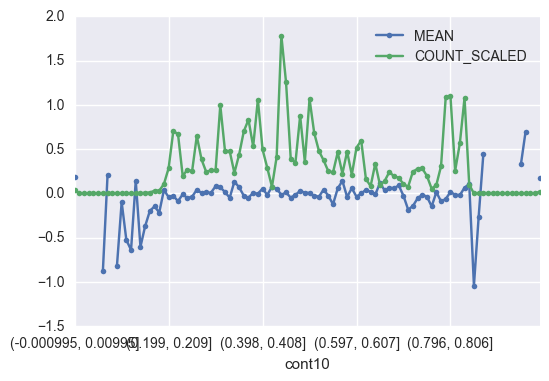

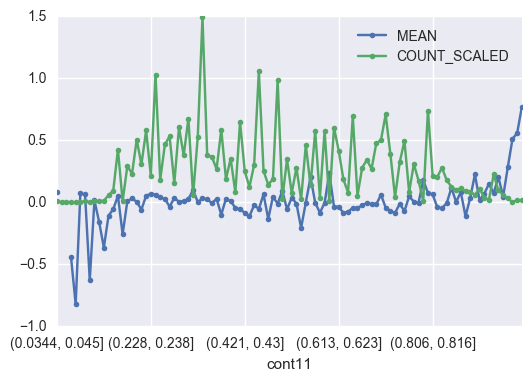

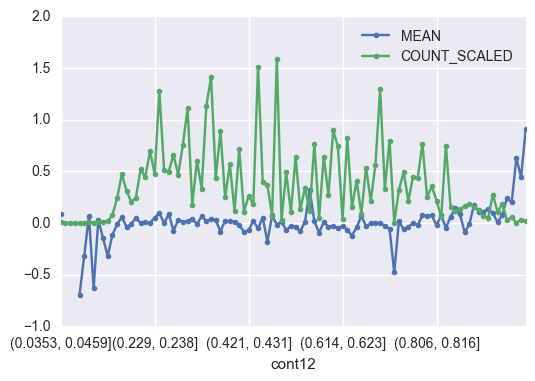

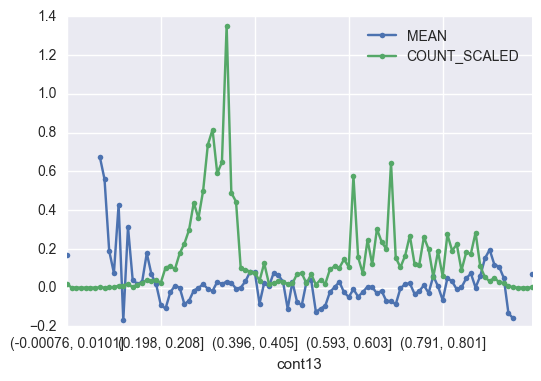

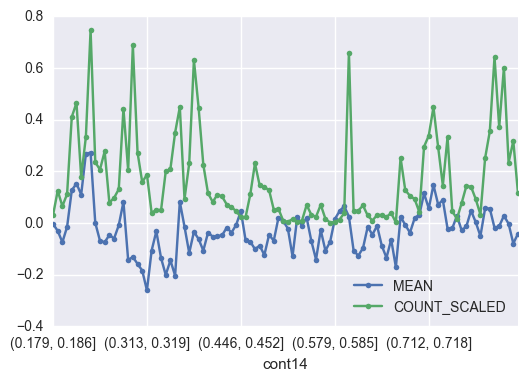

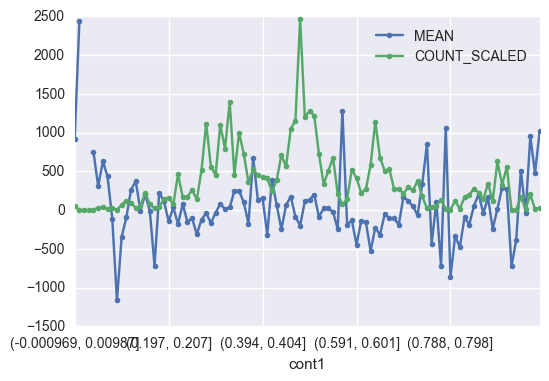

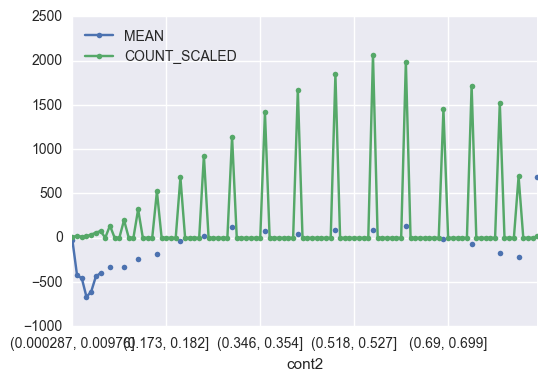

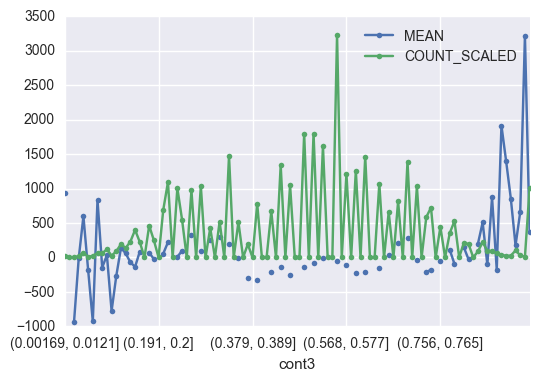

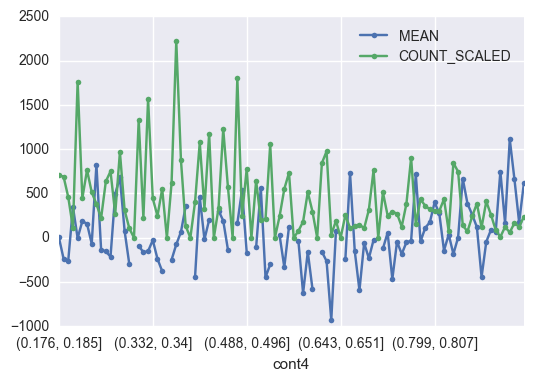

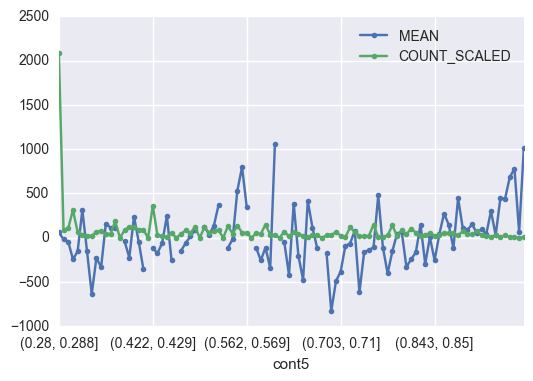

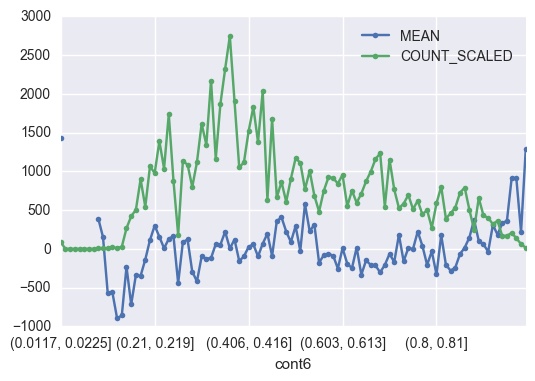

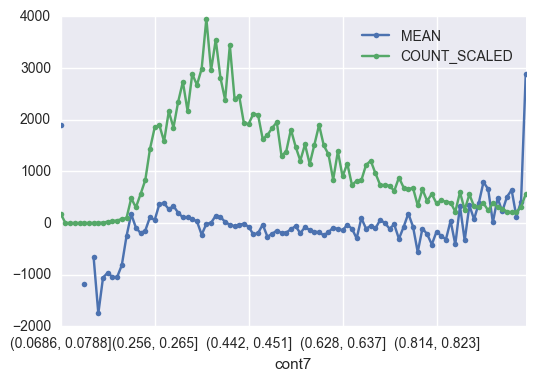

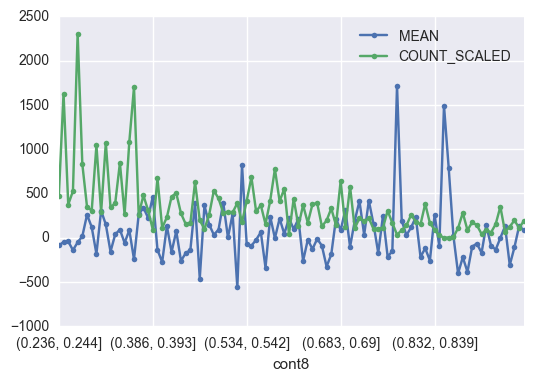

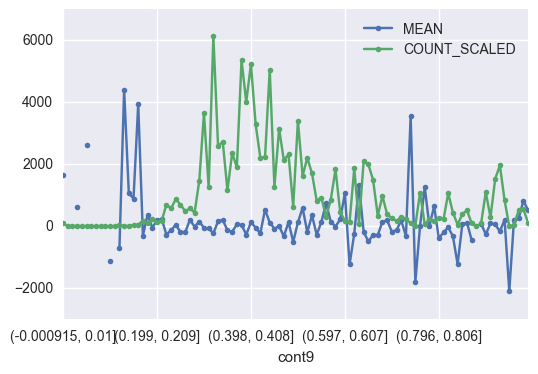

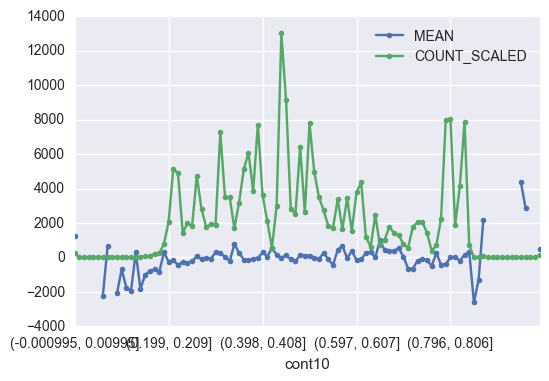

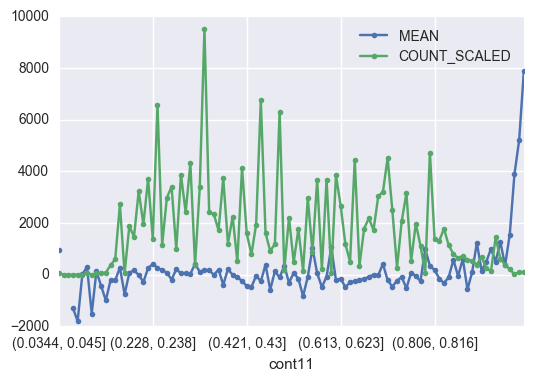

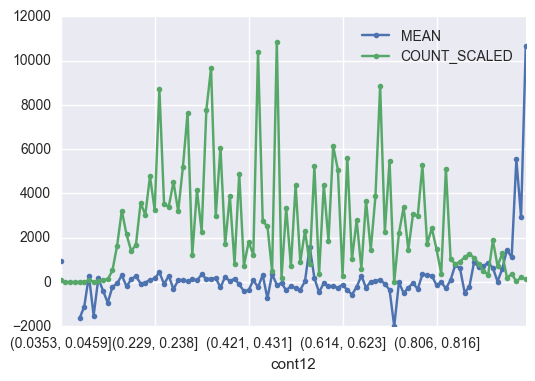

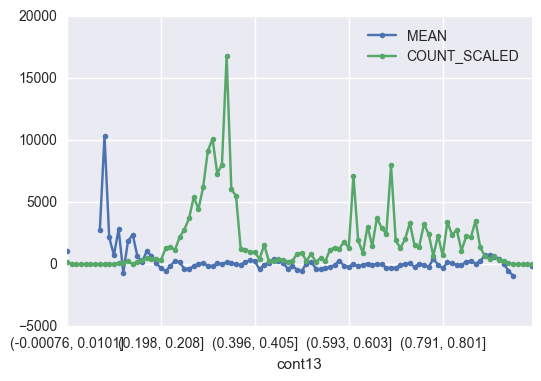

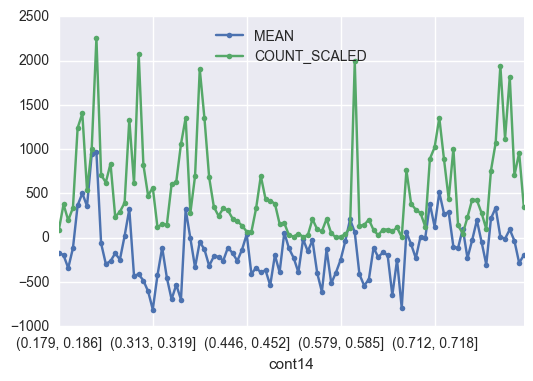

In [57]:
df_cut = []
for col in num_feats:
    df_cut.append(plot_resid_cont_loss(col, 'logloss'))
for col in num_feats:
    df_cut.append(plot_resid_cont_loss(col, 'loss'))

mu=-3.40401578897e-15, sigma=0.663398725869
mu=-1.81959421269e-14, sigma=0.65924710866
mu=-9.88392911663e-15, sigma=0.660899253116
mu=-8.05542802863e-15, sigma=0.663137589098
mu=1.14414838593e-14, sigma=0.663369424788
mu=8.91022865823e-15, sigma=0.663109281083
mu=-2.05728114892e-14, sigma=0.660817039539
mu=-9.25250546806e-15, sigma=0.663099064716
mu=5.10662737954e-15, sigma=0.663351357984
mu=-3.36479440951e-15, sigma=0.663396171318
mu=-5.74582833147e-15, sigma=0.66155014518
mu=2.0191553835e-14, sigma=0.661580099797
mu=-1.39073040654e-14, sigma=0.663429351176
mu=-6.42606175109e-17, sigma=0.663240652428
mu=1.27951499868e-11, sigma=2903.9340157
mu=-1.79203792347e-10, sigma=2874.85440658
mu=5.03233998144e-11, sigma=2886.12281858
mu=-6.06497226227e-14, sigma=2902.2213866
mu=3.36149807801e-12, sigma=2903.8989761
mu=1.14062143498e-11, sigma=2901.64822712
mu=-1.46182155463e-11, sigma=2883.17148687
mu=-1.67970995732e-11, sigma=2902.73436635
mu=8.278194522e-12, sigma=2903.78274578
mu=7.489649121

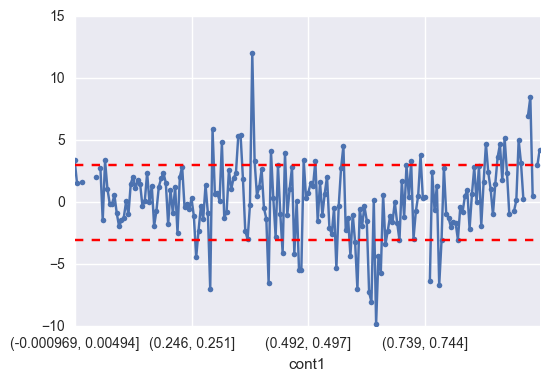

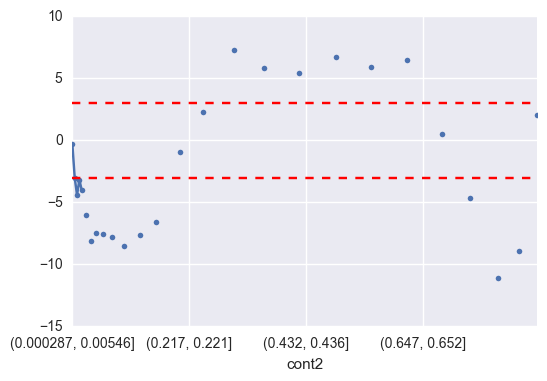

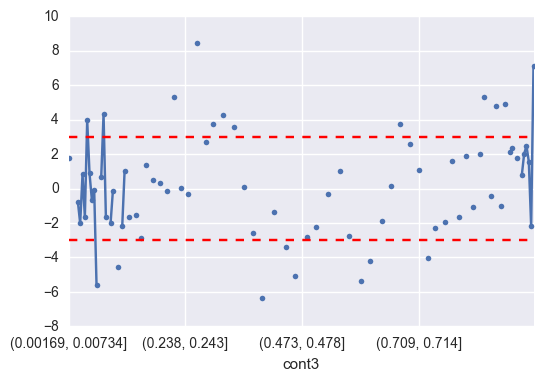

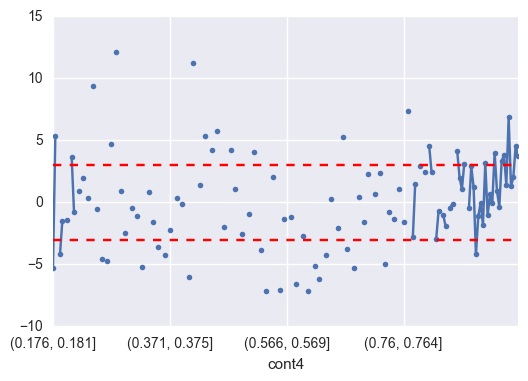

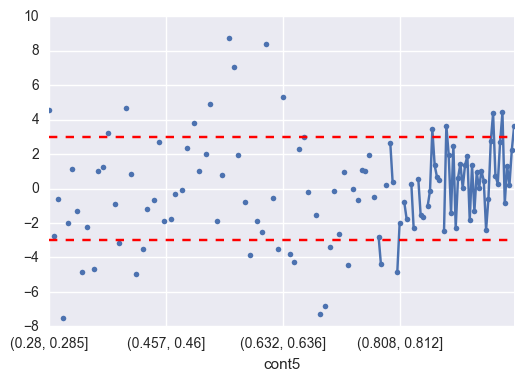

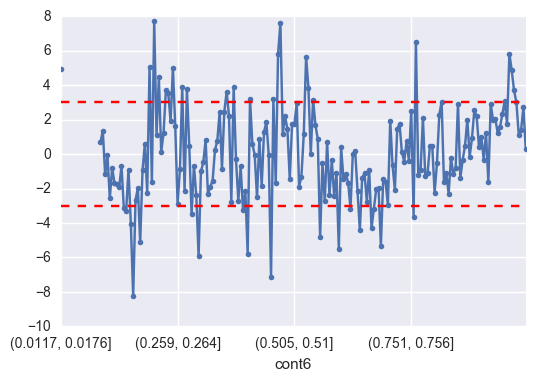

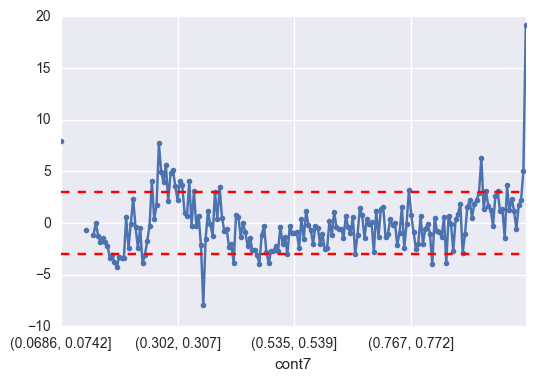

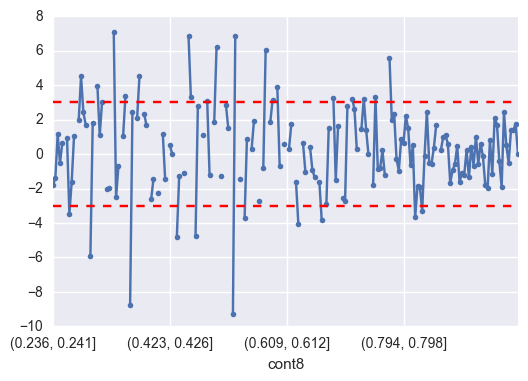

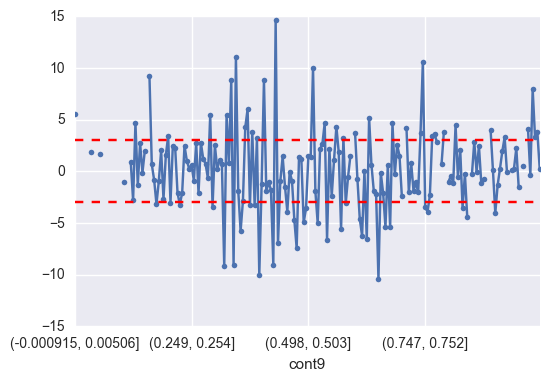

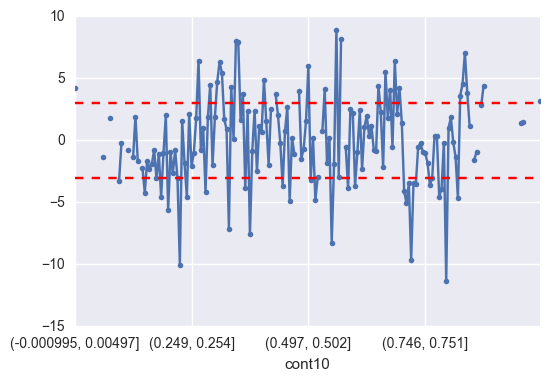

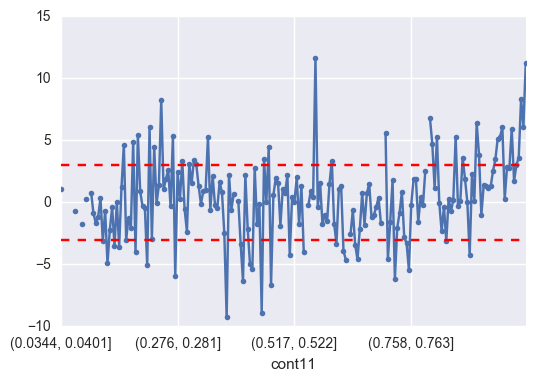

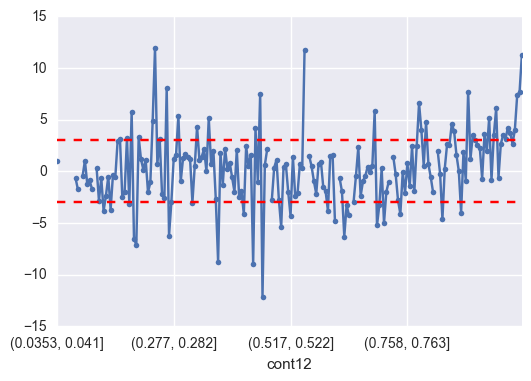

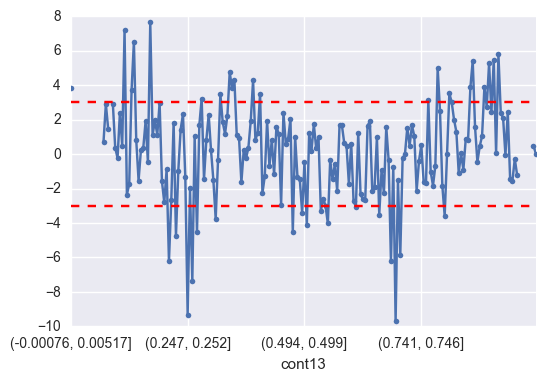

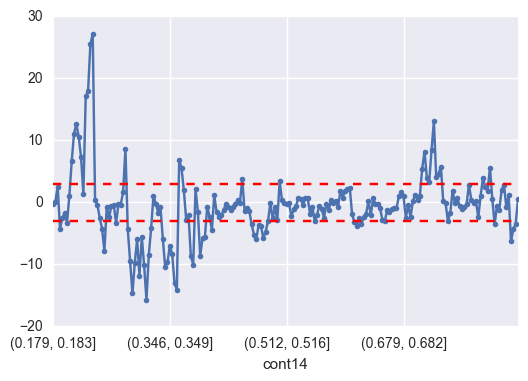

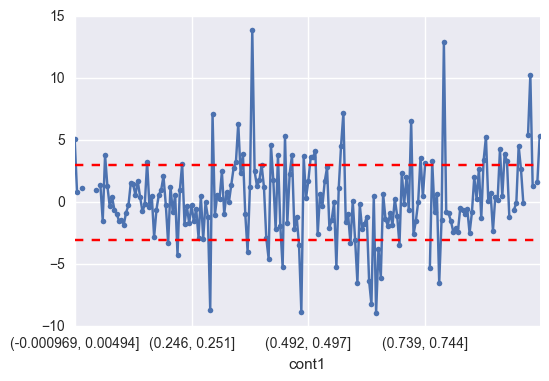

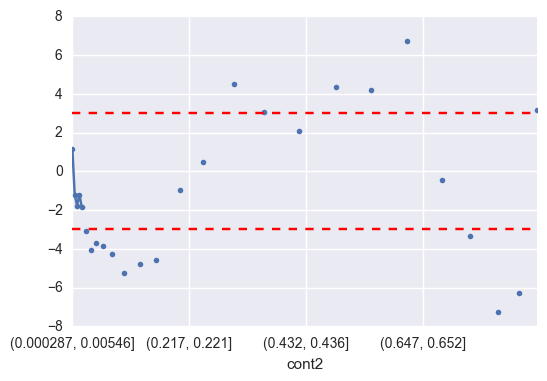

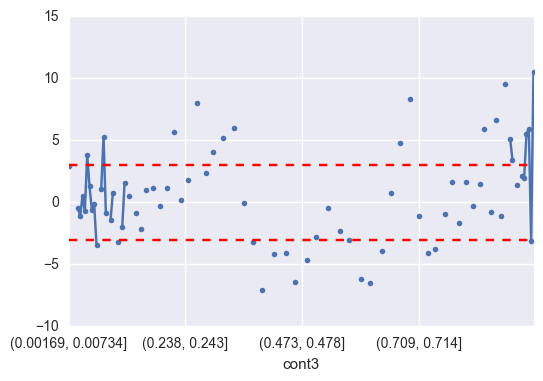

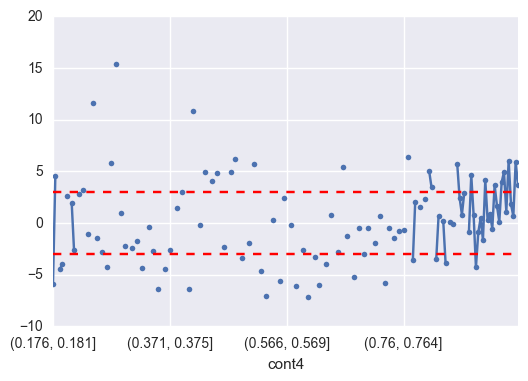

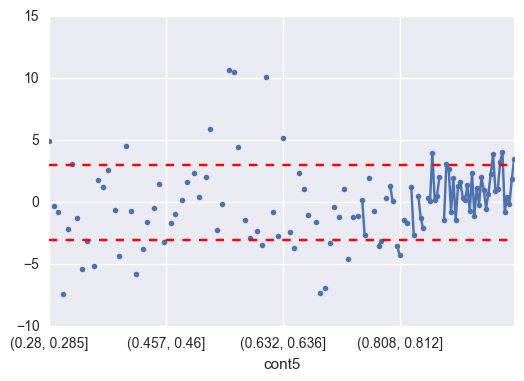

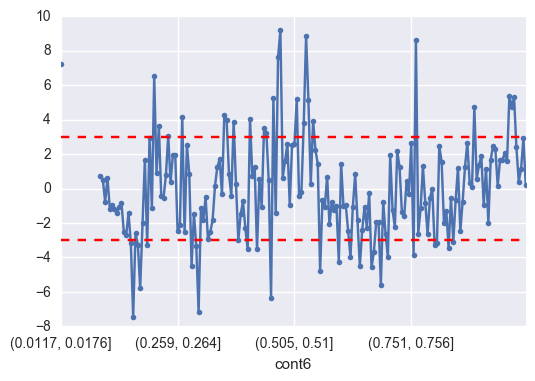

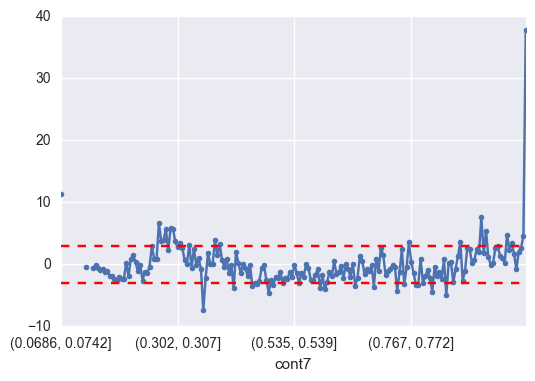

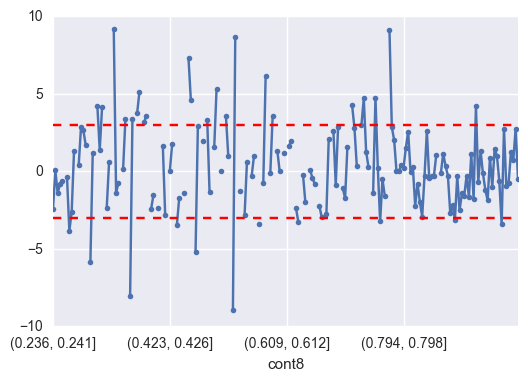

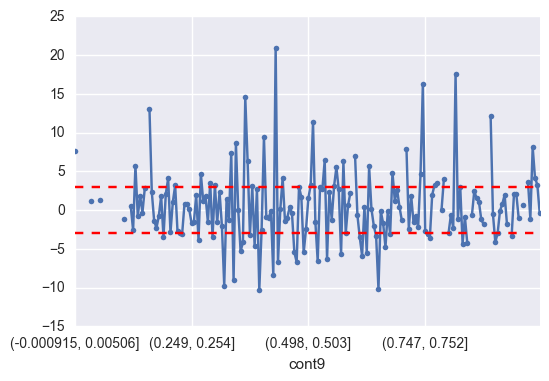

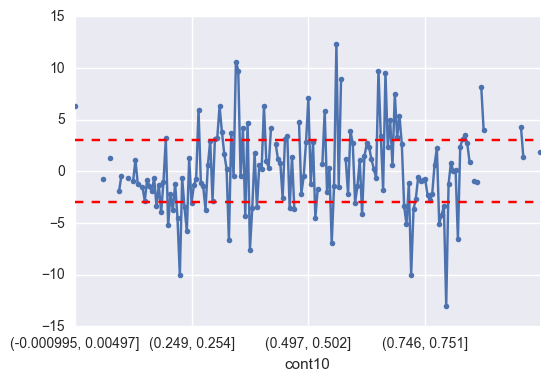

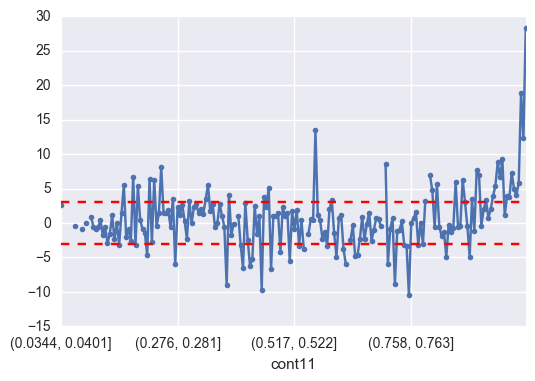

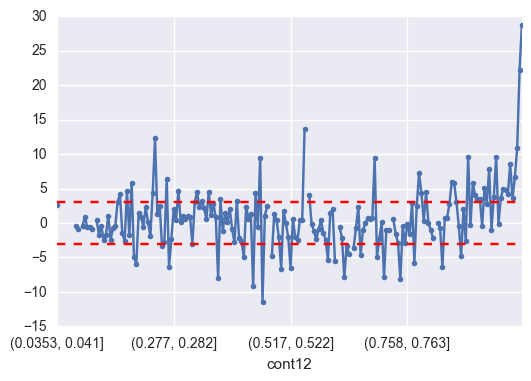

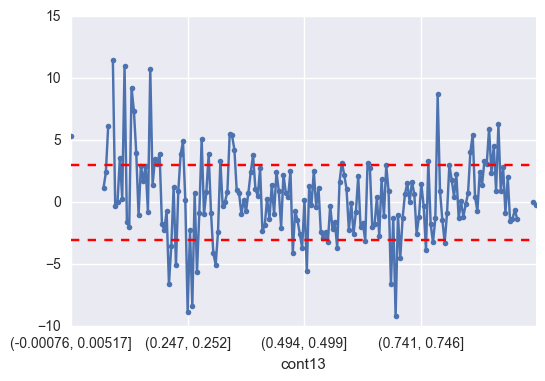

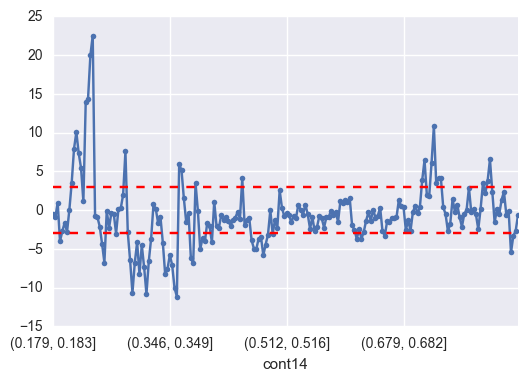

In [59]:
df_z = []
for col in num_feats:
    df_z.append(plot_zscore_cont_loss(col, 'logloss'))
for col in num_feats:
    df_z.append(plot_zscore_cont_loss(col, 'loss'))

In [45]:
print(df_z[0])

                         0.25       0.5      0.75     ZSCORE      MEAN  \
cont1                                                                    
(-0.000969, 0.0197] -0.439992  0.077792  0.685258   3.843170  0.158422   
(0.0197, 0.0394]          NaN       NaN       NaN        NaN       NaN   
(0.0394, 0.0591]    -0.276227  0.190006  0.611695   3.276114  0.159789   
(0.0591, 0.0788]    -0.472262  0.043043  0.590280   2.847852  0.114764   
(0.0788, 0.0985]    -0.456976  0.009573  0.453402  -0.066031 -0.003330   
(0.0985, 0.118]     -0.528452 -0.034472  0.405266  -1.583595 -0.033490   
(0.118, 0.138]      -0.453003  0.018448  0.619496   3.197324  0.084507   
(0.138, 0.158]      -0.501119 -0.031476  0.547995   2.178008  0.038289   
(0.158, 0.177]      -0.462028 -0.016996  0.418065  -0.353012 -0.010505   
(0.177, 0.197]      -0.431936  0.093795  0.517365   3.428229  0.072798   
(0.197, 0.217]      -0.490451 -0.015247  0.424369   0.027268  0.000522   
(0.217, 0.236]      -0.519940 -0.05255

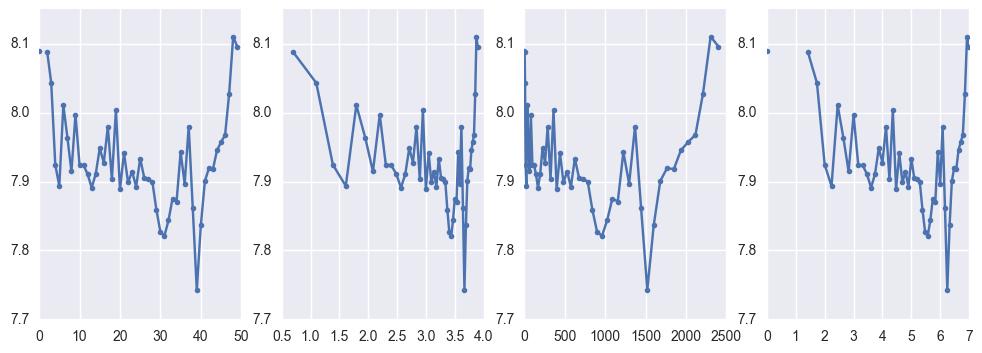

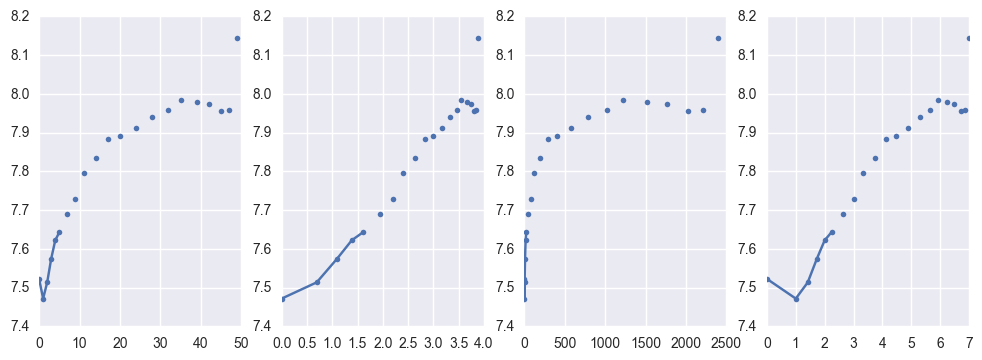

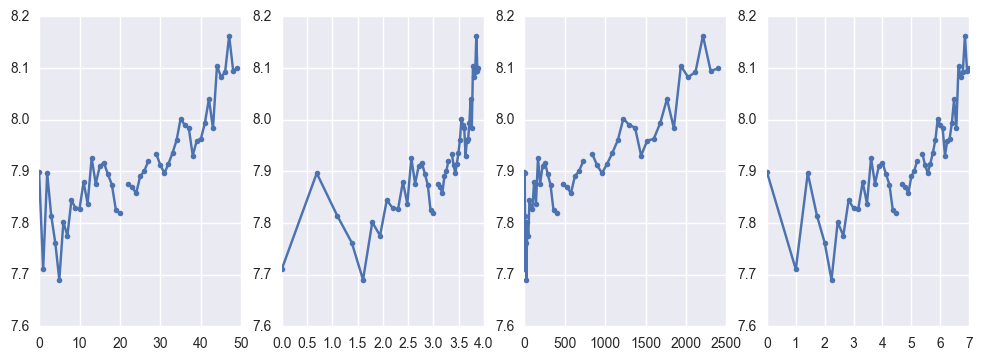

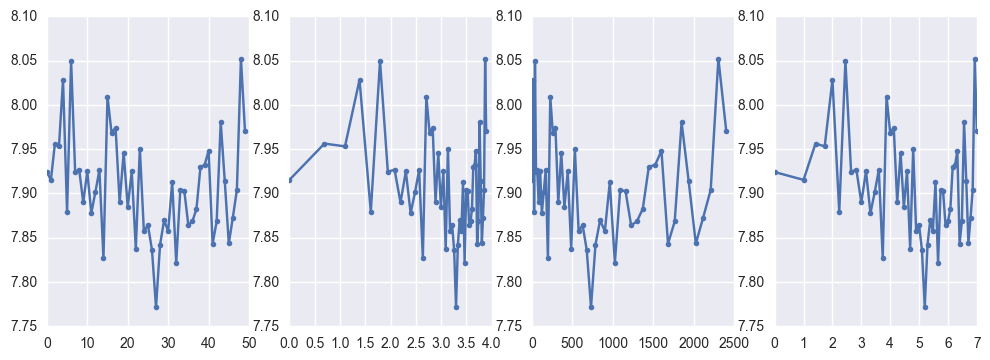

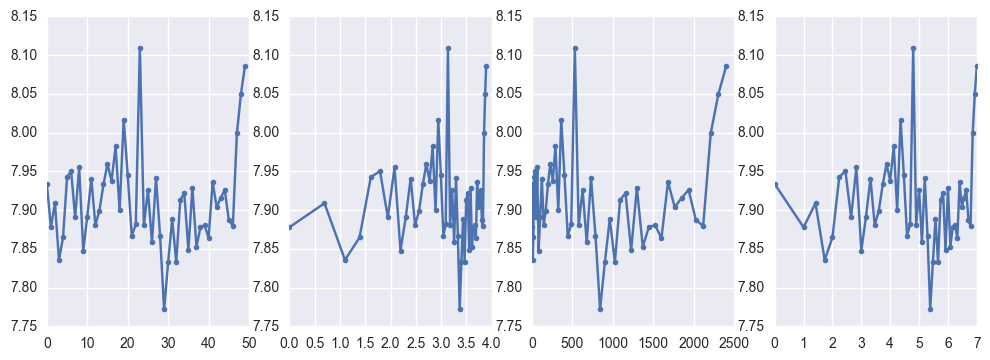

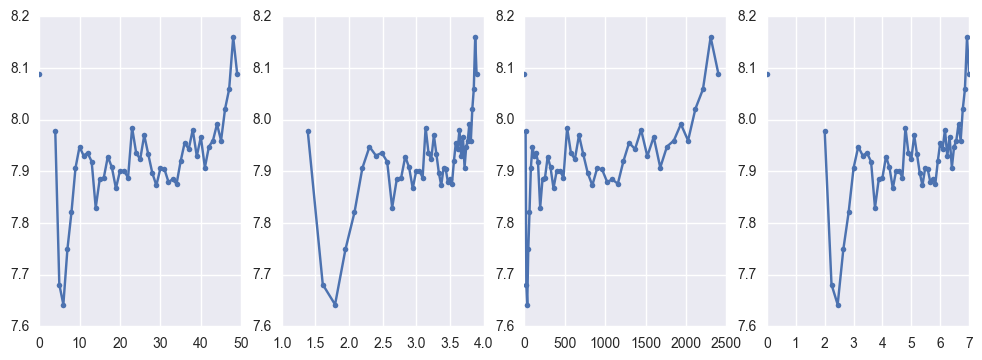

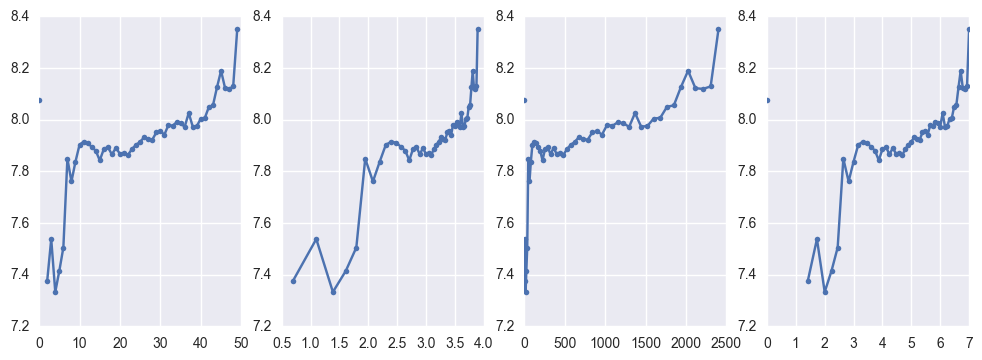

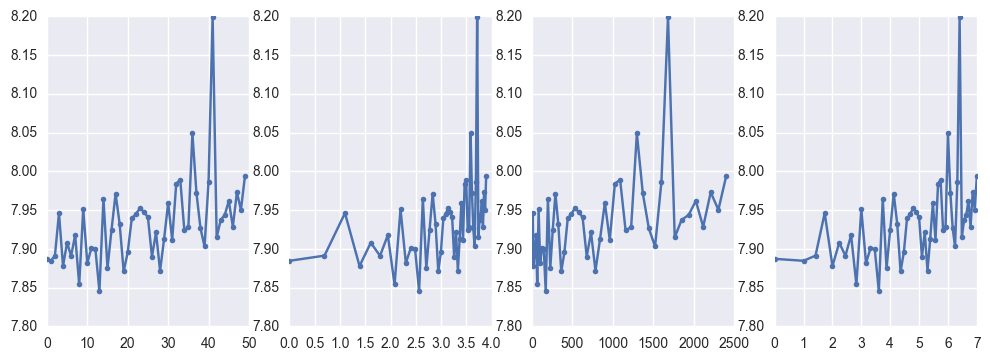

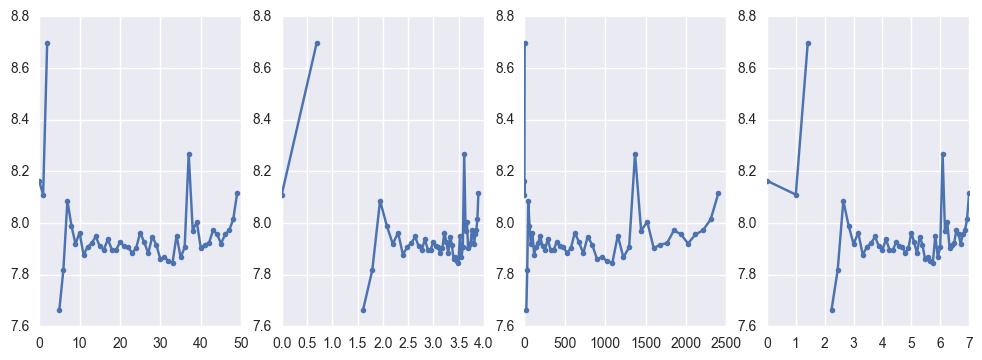

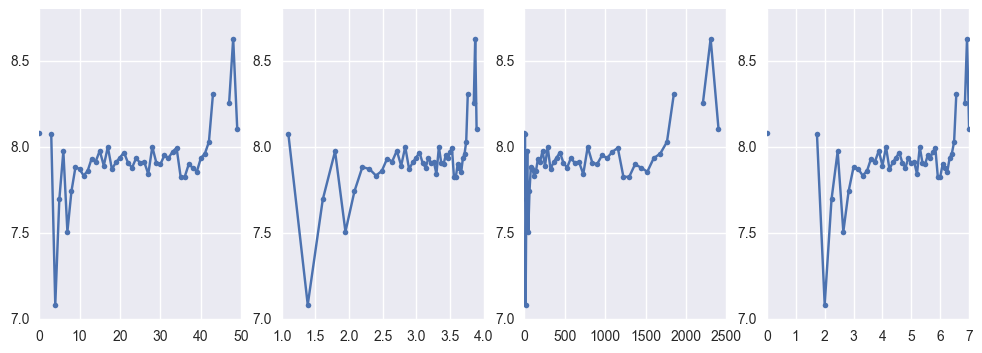

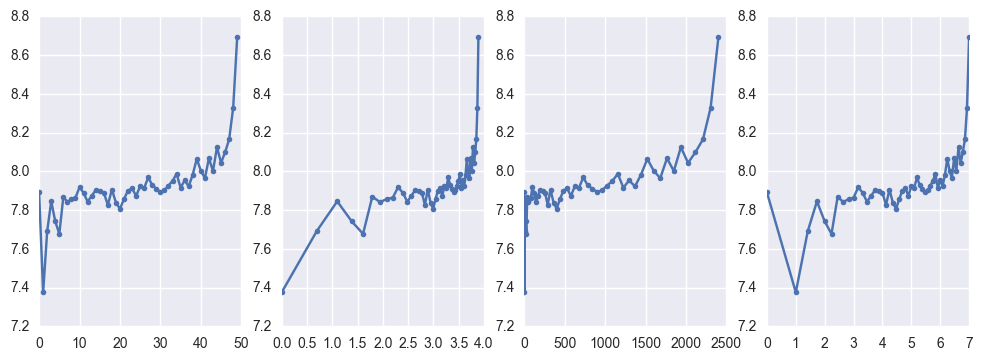

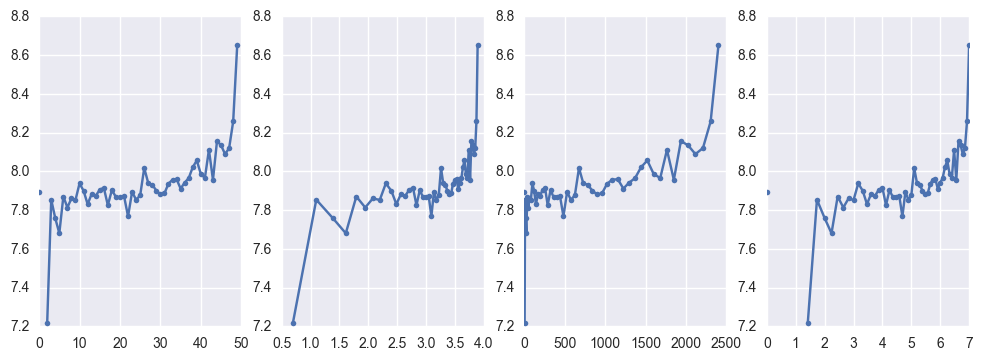

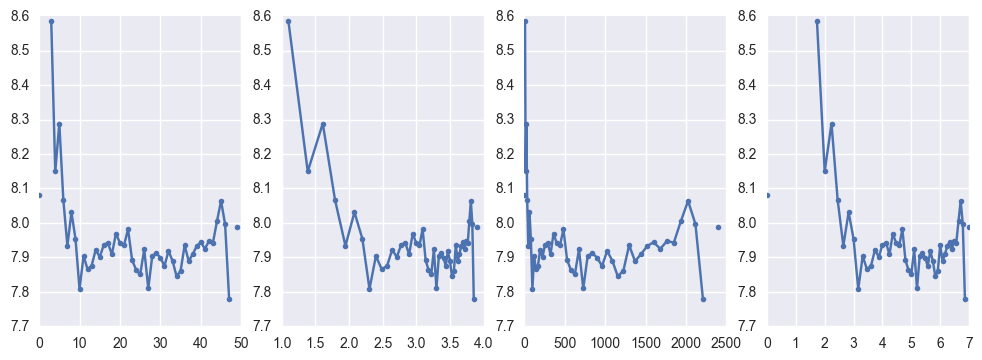

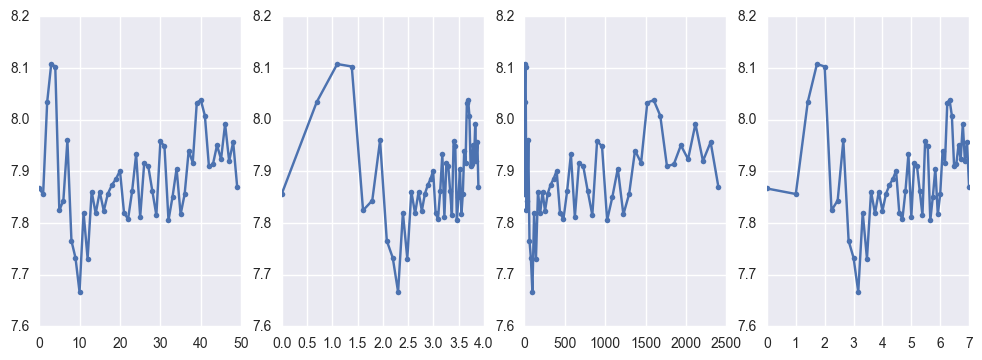

In [79]:
for col in num_feats:
    bins=50
    tmp_data = train[[col,'logloss']].copy()
    tmp_data[col] = pd.cut(tmp_data[col], bins=bins)
    tmp_data = tmp_data.groupby(by=col)['logloss']
    tmp_data_mean = tmp_data.mean()
    tmp_data_std = tmp_data.std()
    tmp_data_count = tmp_data.count()
    tmp_data = tmp_data.quantile([.25,.5,.75]).unstack()
    tmp_data['MEAN'] = tmp_data_mean
    tmp_data['COUNT_SCALED'] = tmp_data_count/float(tmp_data_count.max())*float(tmp_data[.75].max())
    tmp_data['COUNT'] = tmp_data_count
    tmp_data = tmp_data.reset_index()
    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.plot(np.arange(bins), tmp_data.loc[:,'MEAN'], marker='o', markersize=4)
    plt.subplot(142)
    plt.plot(np.log(np.arange(bins)), tmp_data.loc[:,'MEAN'], marker='o', markersize=4)
    plt.subplot(143)
    plt.plot(np.power(np.arange(bins),2), tmp_data.loc[:,'MEAN'], marker='o', markersize=4)
    plt.subplot(144)
    plt.plot(np.sqrt(np.arange(bins)), tmp_data.loc[:,'MEAN'], marker='o', markersize=4)
    #plt.axhline(3, ls='--', c='r')
    #plt.axhline(-3, ls='--', c='r')
    #print "mu={}, sigma={}".format(mu, sigma)